In [2]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

In [3]:
num_features = 6
sequence_length = 20

#Inicializamos la CNN
classifier = Sequential()

#Convolutional layer
# 32 features detectors of 3x3 kernels
classifier.add(Convolution2D(32,3,3,input_shape=(sequence_length,num_features,1), activation = 'relu' ))
#Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))
#Flattening
classifier.add(Flatten())
#Fully connected layer
#Hay que experimentar con el numero de nodos (puede que 128 vaya mejor)
classifier.add(Dense(64,activation = 'relu'))
#Para dos outputs distintos usamos sigmoid pero para mas de dos tendriamos que usar softmax
classifier.add(Dense(1,activation = 'sigmoid'))

#Compiling the CNN
#Con mas de dos clases tendriamos que elegir categorical_crossentropy
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

directory = './spells/dataset2/'

#https://keras.io/api/data_loading/timeseries/
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=["Lumos", "Revelio"],
    color_mode="grayscale",
    batch_size=32,
    image_size=(20, 6),
    shuffle=True,
    seed=123423,
    validation_split=0.2,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)


normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


classifier.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

classifier.summary()

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.03137255 0.9921569
Epoch 1/50
5/5 [==============================] - 1s 48ms/step - loss: 8.5791 - accuracy: 0.4688 - val_loss: 6.1841 - val_accuracy: 0.4500
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 5.0843 - accuracy: 0.4938 - val_loss: 2.1028 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 2.1815 - accuracy: 0.6125 - val_loss: 2.0573 - val_accuracy: 0.6000
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 1.5726 - accuracy: 0.6625 - val_loss: 1.5947 - val_accuracy: 0.6250
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 1.4894 - accuracy: 0.6250 - val_loss: 0.9079 - val

Epoch 1/15
5/5 [==============================] - 0s 12ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9750
Epoch 2/15
5/5 [==============================] - 0s 12ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9750
Epoch 3/15
5/5 [==============================] - 0s 12ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9750
Epoch 4/15
5/5 [==============================] - 0s 12ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 0.9750
Epoch 5/15
5/5 [==============================] - 0s 12ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9750
Epoch 6/15
5/5 [==============================] - 0s 11ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0610 - val_accuracy: 0.9750
Epoch 7/15
5/5 [==============================] - 0s 11ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.9750
Epoch 8/15
5/5 [===========

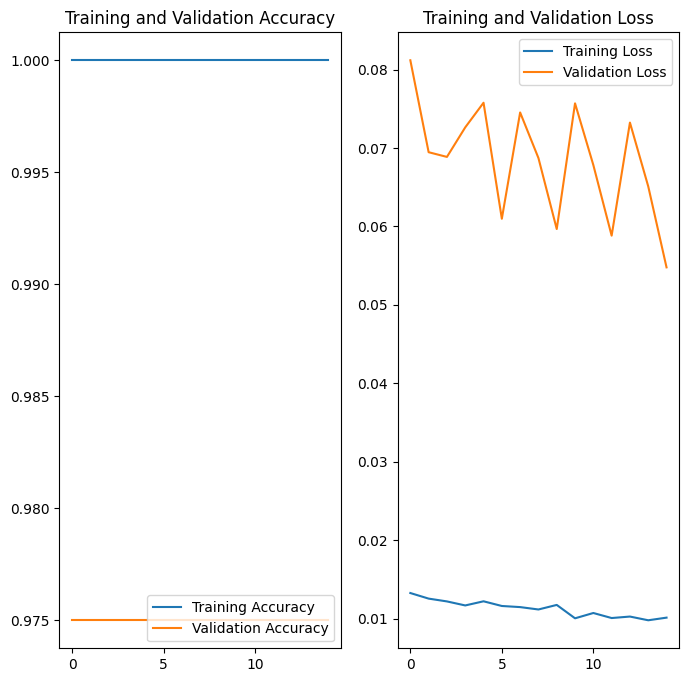

In [4]:
epochs = 15
history = classifier.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
st = time.time()

img = tf.keras.utils.load_img(
    './testImage.jpeg',
    color_mode="grayscale",
    target_size=(20,6),
    interpolation="nearest",
    keep_aspect_ratio=True,
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

class_names = train_ds.class_names

predictions = classifier.predict(img_array)
score = tf.nn.softmax(predictions[0])

et = time.time()

print("Result in: ", round(et-st,2))

print(predictions)

if predictions[0][0] > 0.5:
    print("Este hechizo es de tipo {} con {:.2f} % de confianza.".format(class_names[1], 100 * np.max(score)))
else: 
    print("Este hechizo es de tipo {} con {:.2f} % de confianza.".format(class_names[0], 100 * np.max(score)))     


1/1 [==============================] - 0s 19ms/step
Result in:  0.06
[[0.00143091]]
Este hechizo es de tipo Lumos con 100.00 % de confianza.


In [50]:
#Guardamos el modelo

classifier.save('./classifier')

INFO:tensorflow:Assets written to: ./classifier\assets


INFO:tensorflow:Assets written to: ./classifier\assets
